## Modélisation

### Importer les librairies nécessaires

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

# Options graphiques
sns.set_style("whitegrid")
%matplotlib inline
pd.options.display.float_format = "{:,}".format


# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter


from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


# Import fitting tools

from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV

# Chargement des modules de prétraitement des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# Analyse des courbes d'apprentissage
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

# Import metrics tools
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import (
    f1_score,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold
import eli5
from eli5.sklearn import PermutationImportance
import joblib

# Settings
import warnings

warnings.filterwarnings("ignore")

In [3]:
import os

root_dir = "C://Users//Jess//Desktop//OpenClassrooms//Projet_7//"
os.chdir(root_dir)

### Importation des jeux de données


In [4]:
# Importer les jeux de données
X_training = pd.read_csv("./datasets/df_final_2.csv")

In [5]:
X_training.sample(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,DAYS_DECISION,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_INSTALMENT_FUTURE,SK_DPD_y
221037,356058,0,Cash loans,M,0,"135,000.0","900,000.0",Unaccompanied,working,low_educ,...,-577.6666666666666,22.5,"365,243.0",-628.25,-622.75,Approved,XAP,Repeater,11.538461538461538,0.0


In [6]:
X_training.columns=X_training.columns.str.lower()

In [7]:
all_clients = X_training["sk_id_curr"].tolist()

len(all_clients)

307511

In [8]:
# Uniformiser le nom des colonnes
# X_training = X_training.rename(columns=str.lower)
X_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   sk_id_curr                   307511 non-null  int64  
 1   target                       307511 non-null  int64  
 2   name_contract_type           307511 non-null  object 
 3   code_gender                  307511 non-null  object 
 4   cnt_children                 307511 non-null  int64  
 5   amt_income_total             307511 non-null  float64
 6   amt_credit_x                 307511 non-null  float64
 7   name_type_suite              306219 non-null  object 
 8   name_income_type             307511 non-null  object 
 9   name_education_type          307511 non-null  object 
 10  name_family_status           307511 non-null  object 
 11  region_population_relative   307511 non-null  float64
 12  days_birth                   307511 non-null  int64  
 13 

In [9]:
# X_training = X_training.set_index('sk_id_curr', drop=False)
X_training[X_training["sk_id_curr"] == 115393]

,sk_id_curr,target,name_contract_type,code_gender,cnt_children,amt_income_total,amt_credit_x,name_type_suite,name_income_type,name_education_type,...,days_decision,cnt_payment,days_first_drawing,days_last_due,days_termination,name_contract_status,code_reject_reason,name_client_type,cnt_instalment_future,sk_dpd_y
13210,115393,0,Revolving loans,M,0,"360,000.0","225,000.0",Unaccompanied,working,high_educ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
(X_training['target'].value_counts())

0    282686
1     24825
Name: target, dtype: int64

### Selectionner X et y

In [11]:
X = X_training.drop(["target", "sk_id_curr"], axis=1)
y = X_training["target"]

In [12]:
print(X.shape)
print(y.shape)

(307511, 45)
(307511,)


### Features selection

In [13]:
X_training["name_income_type"] = X_training["name_income_type"].fillna("non_renseigne")

In [14]:
list_col = X_training.columns
for col in list_col:
    print(col)
    print(X_training[col].unique())

sk_id_curr
[100002 100003 100004 ... 456253 456254 456255]
target
[1 0]
name_contract_type
['Cash loans' 'Revolving loans']
code_gender
['M' 'F' 'XNA']
cnt_children
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
amt_income_total
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]
amt_credit_x
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]
name_type_suite
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
name_income_type
['working' 'not_working']
name_education_type
['low_educ' 'high_educ']
name_family_status
['not_married' 'married' 'other']
region_population_relative
[0.018801 0.003541 0.010032 0.008019 0.028663 0.035792 0.003122 0.018634
 0.019689 0.0228   0.015221 0.031329 0.016612 0.010006 0.020713 0.010966
 0.04622  0.025164 0.006296 0.026392 0.018029 0.019101 0.030755 0.008575
 0.01885  0.006207 0.009175 0.007305 0.007114 0.009334 0.022625 0.01452
 0.006629 0.00733  0.032561 0.00496  0.072508 0.009657 0.0

In [15]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)


cat_feat = X.select_dtypes("object").columns
num_feat = X.select_dtypes(np.number).columns

cat_pip = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)
num_pip = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

transformer = make_column_transformer((cat_pip, cat_feat), (num_pip, num_feat)).fit(
    X_train
)
X_train_bis = transformer.transform(X_train)
X_test_bis = transformer.transform(X_test)
print(X_train_bis.shape)
print(X_test_bis.shape)

(215257, 75)
(92254, 75)


In [16]:
joblib.dump(transformer, "./models/transformer.sav")

['./models/transformer.sav']

In [17]:
# Smote

sm = SMOTE(random_state=0)

X_sm, y_sm = sm.fit_resample(X_train_bis, y_train)


counter = Counter(y_sm)
print(counter)

Counter({0: 197795, 1: 197795})


In [18]:
ridge = RidgeClassifierCV()
logistic = LogisticRegression(n_jobs=-1)
dummy = DummyClassifier()
lgbm = LGBMClassifier(n_jobs=-1)

In [19]:
# Créer un dictionnaire de modeles
models = {"ridge": ridge, "logistic": logistic, "dummy": dummy, "lgbm": lgbm}

In [20]:
# Instanciation de MLFLOW
import mlflow

# Personnalisation de l'expérience
mlflow.set_experiment('models_pipeline_pred')

# Sauvegarde de l'expérience
mlflow.sklearn.autolog(silent=True)

In [21]:
def evaluation(model):
    # Evaluation avec mlflow
    with mlflow.start_run(run_name="models_pipeline_pred"):

        # Make custom scoring metric
        scorer = make_scorer(f1_score, pos_label=1)

        # Fit
        model.fit(X_sm, y_sm)

        N, train_score, val_score = learning_curve(
            model,
            X_sm,
            y_sm,
            scoring="accuracy",
            cv=KFold(5),
            train_sizes=np.linspace(0.1, 1, 10),
        )

        # Affichage des courbes d'apprentissage
        plt.figure(figsize=(10, 6))
        plt.plot(N, train_score.mean(axis=1), label="Entrainement")
        plt.plot(N, val_score.mean(axis=1), label="Validation")
        plt.title({name})
        plt.legend()

ridge
logistic
dummy
lgbm


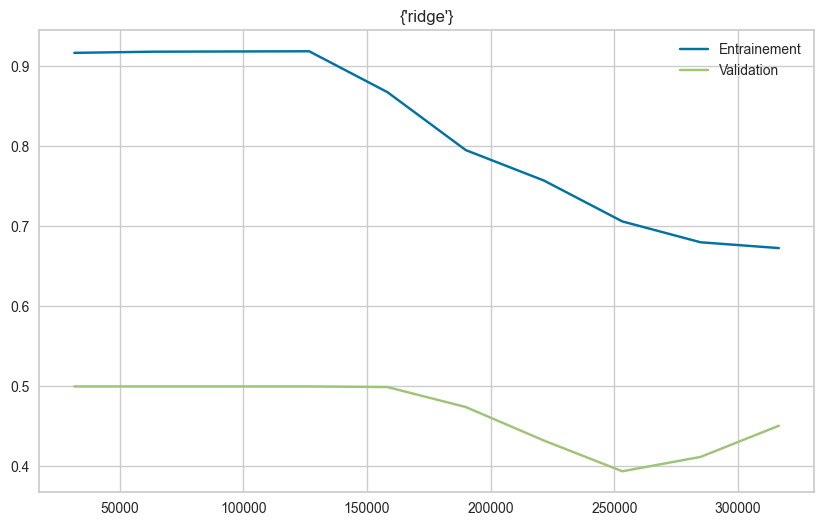

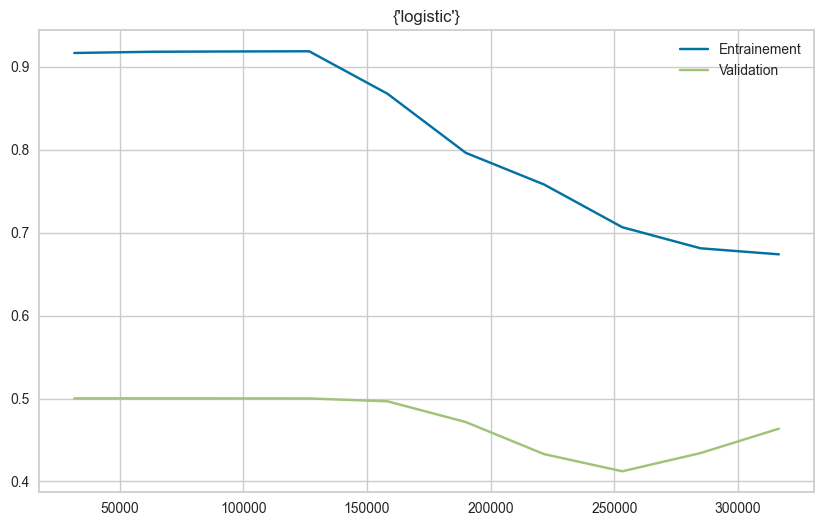

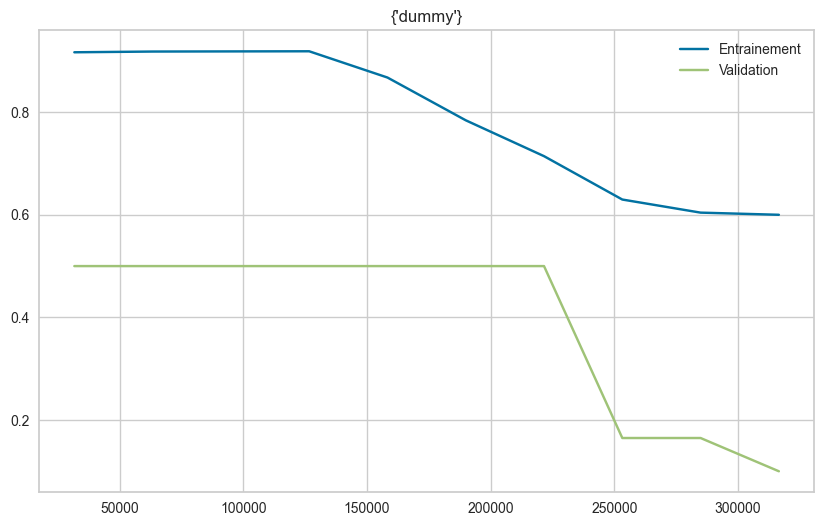

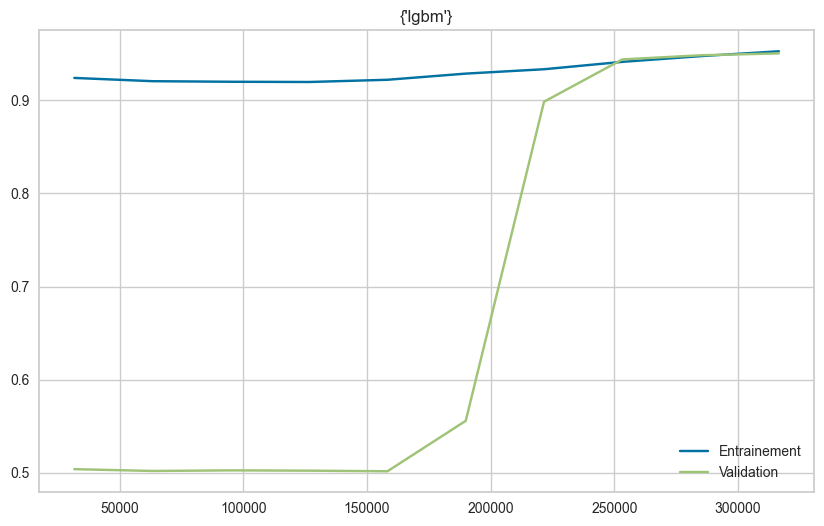

In [22]:
# Boucle for pour utiliser la liste des models dans la fonction d'évaluation
for name, model in models.items():
    print(name)
    evaluation(model)

### Prédictions

In [23]:
# Inclure mlflow
def prediction(model):
    # Inclure mlflow
    with mlflow.start_run(run_name="models_pipeline_pred"):
        
        model.fit(X_sm, y_sm)
        # Prédiction
        y_test_pred = model.predict(X_test_bis)
        print(f'f1_score : {f1_score(y_test, y_test_pred)}')
        print(f'recall : {recall_score(y_test,y_test_pred)}')
        print(f'roc_auc : {roc_auc_score(y_test, y_test_pred)}')
        print('-'*30)
        print('')

        # print results
        print(classification_report(y_test, y_test_pred))

In [24]:
# Boucle for pour la prédiction des modèles après l'optimisation
for name, model in models.items():
    print(name)
    prediction(model)
    print("-" * 50)

ridge
f1_score : 0.2188999115085464
recall : 0.6383267689800353
roc_auc : 0.6372889808429879
------------------------------

              precision    recall  f1-score   support

           0       0.95      0.64      0.76     84891
           1       0.13      0.64      0.22      7363

    accuracy                           0.64     92254
   macro avg       0.54      0.64      0.49     92254
weighted avg       0.89      0.64      0.72     92254

--------------------------------------------------
logistic
f1_score : 0.219682748263563
recall : 0.6357462990628819
roc_auc : 0.6378069469893576
------------------------------

              precision    recall  f1-score   support

           0       0.95      0.64      0.77     84891
           1       0.13      0.64      0.22      7363

    accuracy                           0.64     92254
   macro avg       0.54      0.64      0.49     92254
weighted avg       0.89      0.64      0.72     92254

-------------------------------------------

In [25]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [26]:
# Instanciation de MLFLOW
import mlflow

# Personnalisation de l'expérience
mlflow.set_experiment('model_lgbm')

# Sauvegarde de l'expérience
mlflow.sklearn.autolog(silent=True)

In [27]:
# Utiliser randomizerSearchcv

lgb_params =  {
    'colsample_bytree': [0.5, 0.8, 1],
    'subsample': [0.5, 0.8, 1],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [10, 12, 14],
    'n_estimators': [200, 300, 400, 500],
    'num_leaves': [12,32,64],
    'n_jobs': [-1]
    }

iterations = np.arange(1,11)
cv = KFold(5)

from tqdm import tqdm

for iter in tqdm(iterations):
    with mlflow.start_run(run_name="model_lgbm"):

        grid = RandomizedSearchCV(estimator=lgbm, 
                              param_distributions=lgb_params, 
                              cv=cv, 
                              n_iter=iter, 
                              scoring="accuracy", 
                              n_jobs=-1,
                              random_state=101)

        grid.fit(X_sm, y_sm)
        

100%|██████████| 10/10 [48:46<00:00, 292.67s/it]


In [28]:
# Evaluation
print(grid.best_score_)
print(grid.best_params_)

0.9534973078187011
{'subsample': 1, 'num_leaves': 64, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [33]:
model_final = grid.best_estimator_

In [34]:
def prediction(model):
    with mlflow.start_run(run_name="model_lgbm"):
          
        # Prédiction
        y_test_pred_lgbm = model.predict(X_test_bis)

        # Metrics
        print(f'f1_score : {f1_score(y_test, y_test_pred_lgbm)}')
        print(f'recall : {recall_score(y_test,y_test_pred_lgbm)}')
        print(f'roc_auc : {roc_auc_score(y_test, y_test_pred_lgbm)}')
        print('-'*30)
        print('')

        # print results
        print(classification_report(y_test, y_test_pred_lgbm))

In [35]:
prediction(model_final)

f1_score : 0.031461258450338016
recall : 0.01643351894608176
roc_auc : 0.5069916590501456
------------------------------

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84891
           1       0.37      0.02      0.03      7363

    accuracy                           0.92     92254
   macro avg       0.64      0.51      0.49     92254
weighted avg       0.88      0.92      0.88     92254



In [37]:
model_final.predict(X_test_bis)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Scoring

#### Logistic

In [38]:
# Scoring

y_train_pred_log = logistic.predict_proba(X_sm)
print(
    "ROC-AUC Logistic Regression Train: {}".format(
        roc_auc_score(y_sm, y_train_pred_log[:, 1])
    )
)

y_test_proba_log = logistic.predict_proba(X_test_bis)
# get ROC AUC score

print(
    "ROC-AUC Logistic Regression Test: {}".format(
        roc_auc_score(y_test, y_test_proba_log[:, 1])
    )
)

ROC-AUC Logistic Regression Train: 0.7087694193558939
ROC-AUC Logistic Regression Test: 0.6848277462828467


In [39]:
df_proba = pd.DataFrame(y_test_proba_log, columns=["prob_0", "prob_1"])
df_proba_target = pd.DataFrame(logistic.predict(X_test_bis), columns=["predict_target"])
df_test_dataset = pd.DataFrame(y_test, columns=["target"]).reset_index()

dfx = pd.concat([df_test_dataset, df_proba, df_proba_target], axis=1)

dfx[dfx["predict_target"] == 1]

,index,target,prob_0,prob_1,predict_target
0,6944,0,0.2971888302531248,0.7028111697468752,1
4,54658,0,0.3203185297382538,0.6796814702617462,1
8,196688,0,0.42771448983491145,0.5722855101650886,1
9,268136,1,0.4787103062477246,0.5212896937522754,1
10,159526,0,0.3105861432614615,0.6894138567385385,1
...,...,...,...,...,...
92239,206172,0,0.25649451344931207,0.7435054865506879,1
92240,232039,0,0.24801133762837269,0.7519886623716273,1
92243,121007,0,0.4248798320594803,0.5751201679405197,1
92246,165856,0,0.4779084812927097,0.5220915187072903,1


In [40]:
# Calcul du seuil
seuil = dfx["prob_1"] - dfx["prob_0"]
dfx["seuil"] = seuil
dfx[dfx["predict_target"] == 0]

,index,target,prob_0,prob_1,predict_target,seuil
1,113701,0,0.5373595046518556,0.4626404953481444,0,-0.07471900930371117
2,229528,0,0.601605791329574,0.398394208670426,0,-0.20321158265914802
3,124879,0,0.7776434768628239,0.2223565231371761,0,-0.5552869537256477
5,239175,0,0.9073929370467607,0.09260706295323924,0,-0.8147858740935214
6,74234,1,0.7708069013210388,0.22919309867896115,0,-0.5416138026420776
...,...,...,...,...,...,...
92249,281960,0,0.5854520862983541,0.41454791370164595,0,-0.17090417259670815
92250,75031,0,0.5879376297500019,0.41206237024999814,0,-0.1758752595000037
92251,123886,0,0.6902776450276643,0.3097223549723357,0,-0.3805552900553286
92252,289236,0,0.7177513443094456,0.2822486556905544,0,-0.43550268861889124


#### Coût métier
Les valeurs des poids sont les suivantes :

- fn_value = -10
- tp_value = 0
- tn_value = 1
- fp_value = -1

In [41]:
# Fonction bank_score
def bank_score(y_true, y_pred, fn_value=-10, fp_value=-1, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)

    tn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    tp = mat_conf[1, 1]

    Gain_tot = tp * tp_value + tn * tn_value + fp * fp_value + fn * fn_value
    G_max = (fp + tn) * tn_value + (fn + tp) * tp_value
    G_min = (fp + tn) * fp_value + (fn + tp) * fn_value

    G_normalized = (Gain_tot - G_min) / (G_max - G_min)

    return G_normalized

In [42]:
# bank score
y_test_pred_log = logistic.predict(X_test_bis)
bank_score(y_test, y_test_pred_log, fn_value=-10, fp_value=-1, tp_value=0, tn_value=1)

0.6386209389841092

In [43]:
# score roc auc logistic
roc_auc_score(y_test, y_test_pred_log)

0.6378069469893576

Best-Threshold=100.00%, G-Mean=63.78%


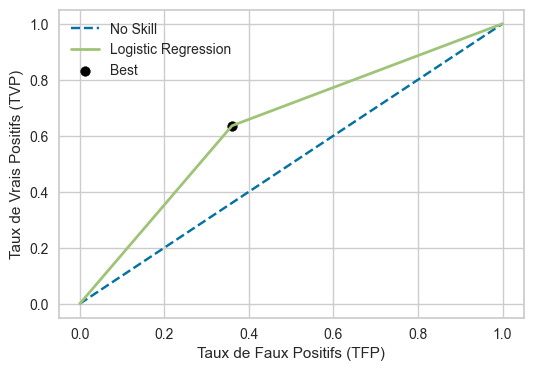

In [44]:
# calculate roc curves
TFP, TVP, thresholds = roc_curve(y_test, y_test_pred_log)

# calculate the g-mean for each threshold
gmeans = np.sqrt(TVP * (1 - TFP))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print(f"Best-Threshold={thresholds[ix]:.2%}, G-Mean={gmeans[ix]:.2%}")

# plot the roc curve for the model

fig, ax = plt.subplots(figsize=(6, 4))

plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(TFP, TVP, linestyle="-", linewidth=2, label="Logistic Regression")
plt.scatter(TFP[ix], TVP[ix], marker="o", color="black", label="Best")
# axis labels
plt.xlabel("Taux de Faux Positifs (TFP)")
plt.ylabel("Taux de Vrais Positifs (TVP)")
plt.legend()
# show the plot
plt.show()

In [45]:
def seuil_optimal_search(y_true, y_prob, score_function):
    thresholds = np.linspace(0.0, 1, 30)
    scores_thresholds = []

    for th in thresholds:
        y_pred = (y_prob[:, 1] - y_prob[:, 0] > th) * 1
        scores_thresholds.append(score_function(y_true, y_pred))
    # Plot
    plt.plot(thresholds, scores_thresholds)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

    idx_best_th = scores_thresholds.index(max(scores_thresholds))
    return thresholds[idx_best_th]

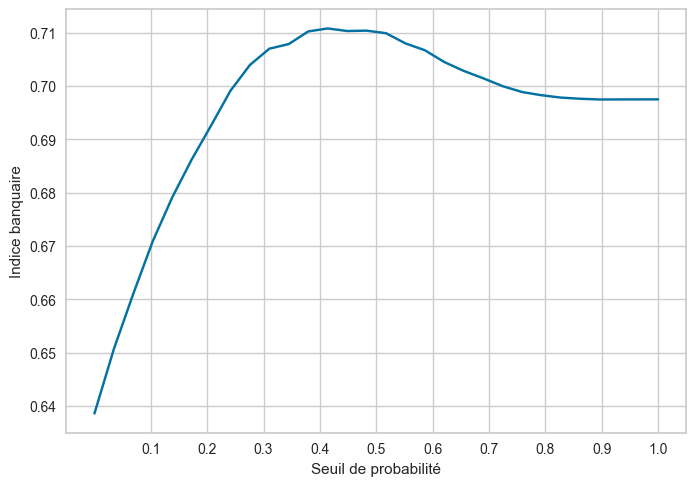

In [46]:
seuil_optimal_log = seuil_optimal_search(y_test, y_test_proba_log, bank_score)

In [47]:
seuil_optimal_log

0.41379310344827586

In [48]:
y_pred_log_optimal = (y_test_proba_log[:, 1] > seuil_optimal_log) * 1
y_pred_log_optimal

array([1, 1, 0, ..., 0, 0, 0])

In [49]:
print("rapport de classification avec la probabilité et le seuil optimal:")
print(classification_report(y_test, y_pred_log_optimal))

rapport de classification avec la probabilité et le seuil optimal:
              precision    recall  f1-score   support

           0       0.96      0.47      0.63     84891
           1       0.11      0.78      0.20      7363

    accuracy                           0.49     92254
   macro avg       0.54      0.62      0.41     92254
weighted avg       0.89      0.49      0.59     92254



#### LGBM 

In [50]:
# Predict proba lgbm
model_final.predict_proba(X_test_bis)

array([[0.82100449, 0.17899551],
       [0.95334996, 0.04665004],
       [0.96051205, 0.03948795],
       ...,
       [0.93659217, 0.06340783],
       [0.95943134, 0.04056866],
       [0.97746711, 0.02253289]])

In [51]:
# Roc Auc Score
y_test_proba_lgbm = model_final.predict_proba(X_test_bis)[:, 1]
roc_auc_score(y_test, y_test_proba_lgbm)

0.7125835169735273

In [52]:
# score bank
y_test_pred_lgbm = model_final.predict(X_test_bis)
bank_score_lgbm = bank_score(
    y_test, y_test_pred_lgbm, fn_value=-10, fp_value=-1, tp_value=0, tn_value=1
)

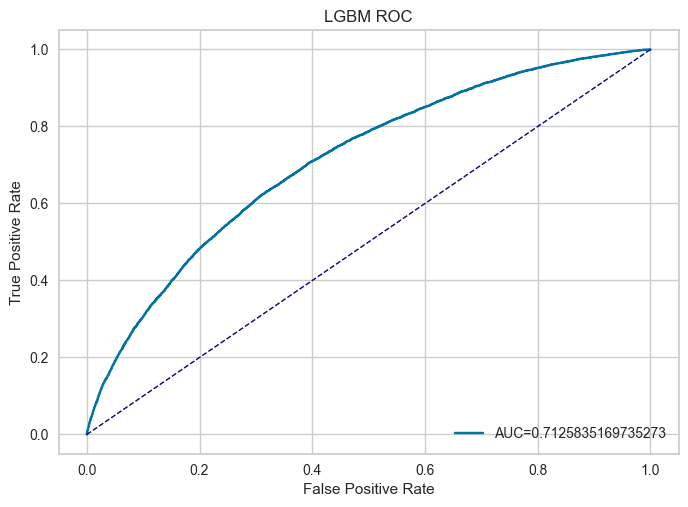

In [53]:
# Afficher la courbe ROC du lgbm
y_pred_proba_lgbm = model_final.predict_proba(X_test_bis)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lgbm)
auc = roc_auc_score(y_test, y_pred_proba_lgbm)
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
# axis labels
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)
plt.title("LGBM ROC")
# show the plot
plt.show()

In [54]:
# Fusion des probalités et des predictions avec la vraie target
y_test_proba_lgbm = model_final.predict_proba(X_test_bis)
df_proba_lgbm = pd.DataFrame(y_test_proba_lgbm, columns=["prob_0", "prob_1"])
df_pred_target_lgbm = pd.DataFrame(
    model_final.predict(X_test_bis), columns=["predict_target"]
)
df_test_dataset_lgbm = pd.DataFrame(y_test, columns=["target"]).reset_index()

df_lgbm = pd.concat([df_test_dataset_lgbm, df_proba_lgbm, df_pred_target_lgbm], axis=1)

In [55]:
# Calcul du seuil
seuil = df_lgbm["prob_1"] - df_lgbm["prob_0"]
df_lgbm["seuil"] = seuil
df_lgbm[df_lgbm["predict_target"] == 1]

,index,target,prob_0,prob_1,predict_target,seuil
157,90849,0,0.4804666034754531,0.5195333965245469,1,0.03906679304909377
322,128687,0,0.4508264409520055,0.5491735590479945,1,0.09834711809598895
682,294773,0,0.4362104407171361,0.5637895592828639,1,0.1275791185657278
932,273929,0,0.43324014016268386,0.5667598598373161,1,0.13351971967463228
1072,271429,1,0.4447758881335313,0.5552241118664687,1,0.11044822373293739
...,...,...,...,...,...,...
91156,59668,0,0.48382640584484526,0.5161735941551547,1,0.03234718831030947
91423,275552,0,0.35074118344831606,0.6492588165516839,1,0.2985176331033679
91496,62407,1,0.46112481336059863,0.5388751866394014,1,0.07775037327880274
92137,296466,0,0.48973837250626984,0.5102616274937302,1,0.020523254987460327


In [56]:
y_test_pred_lgbm = model_final.predict(X_test_bis)

In [57]:
def seuil_optimal_search(y_true, y_prob, score_function):
    thresholds = np.linspace(0.0, 1, 30)
    scores_thresholds = []

    for th in thresholds:
        y_pred = (y_prob[:, 1] > th) * 1
        scores_thresholds.append(score_function(y_true, y_pred))
    # Plot
    plt.plot(thresholds, scores_thresholds)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

    idx_best_th = scores_thresholds.index(max(scores_thresholds))
    return thresholds[idx_best_th]

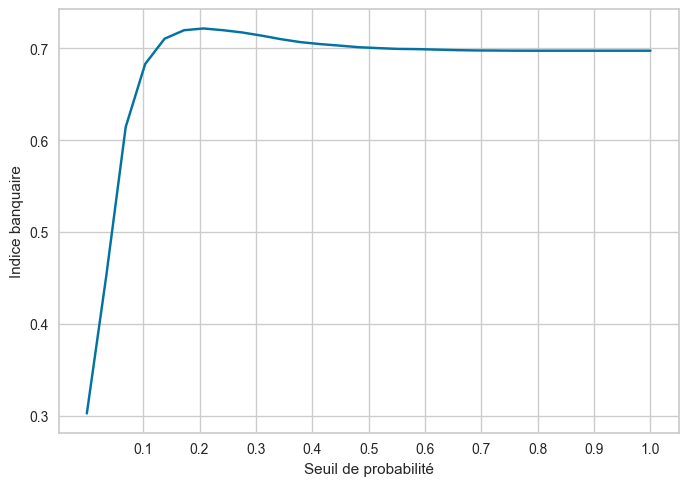

In [58]:
seuil_optimal_lgbm = seuil_optimal_search(y_test, y_test_proba_lgbm, bank_score)

In [59]:
seuil_optimal_lgbm

0.20689655172413793

In [60]:
y_pred_lgbm_optimal = (y_test_proba_lgbm[:, 1] > seuil_optimal_lgbm) * 1
y_pred_lgbm_optimal
# seuil_lgbm = pd.DataFrame(y_pred_lgbm_optimal)
# seuil_lgbm.value_counts()

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
print("rapport de classification avec la prediction:")
print(classification_report(y_test, y_test_pred_lgbm))

rapport de classification avec la prediction:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84891
           1       0.37      0.02      0.03      7363

    accuracy                           0.92     92254
   macro avg       0.64      0.51      0.49     92254
weighted avg       0.88      0.92      0.88     92254



In [62]:
print("rapport de classification avec la probabilité et le seuil optimal:")
print(classification_report(y_test, y_pred_lgbm_optimal))

rapport de classification avec la probabilité et le seuil optimal:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     84891
           1       0.23      0.25      0.24      7363

    accuracy                           0.87     92254
   macro avg       0.58      0.59      0.58     92254
weighted avg       0.88      0.87      0.88     92254



## Confusion matrix


##### Logistic confusion matrix

<Axes: >

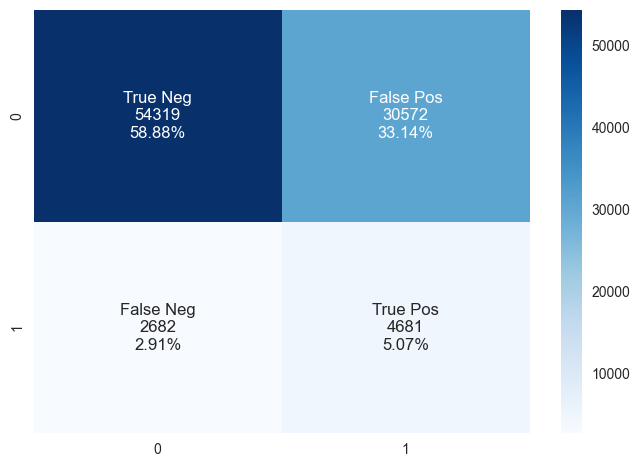

In [63]:
y_test_pred_log = logistic.predict(X_test_bis)
cf_matrix = confusion_matrix(y_test, y_test_pred_log)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

<Axes: >

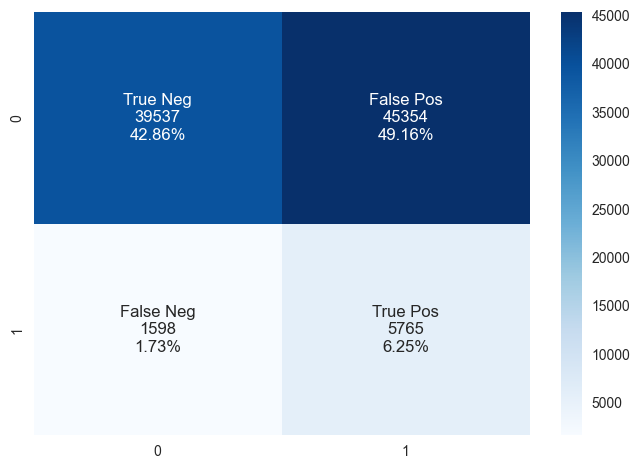

In [64]:
# Confusion matrix avec le seuil optimal
cf_matrix = confusion_matrix(y_test, y_pred_log_optimal)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

##### Ridgecv confusion matrix

<Axes: >

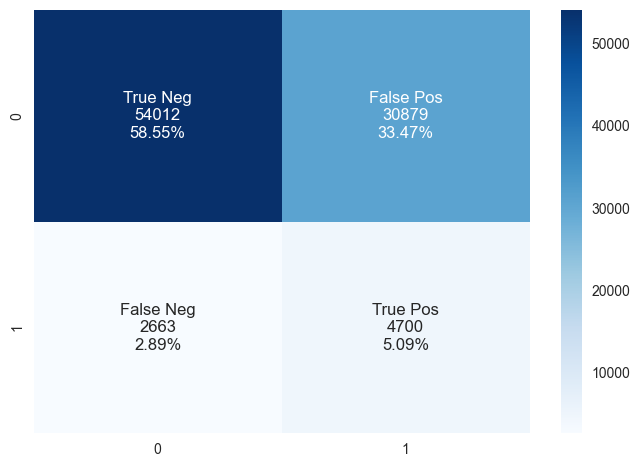

In [65]:
# Compute confusion matrix
y_test_pred_ridge = ridge.predict(X_test_bis)
cf_matrix = confusion_matrix(y_test, y_test_pred_ridge)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

##### LGBM confusion matrix

In [66]:
# Afficher le rapport de classification du LGBM

Y_pred = np.argmax(model_final.predict_proba(X_test_bis), axis=1)
print("Confusion Matrix")
print(multilabel_confusion_matrix(y_test, Y_pred))
print("Classification Report")

Confusion Matrix
[[[  121  7242]
  [  208 84683]]

 [[84683   208]
  [ 7242   121]]]
Classification Report


In [67]:
y_pred = model_final.predict(X_test_bis)
Y_pred = model_final.predict_proba(X_test_bis)
print(y_pred)
print(Y_pred)

[0 0 0 ... 0 0 0]
[[0.82100449 0.17899551]
 [0.95334996 0.04665004]
 [0.96051205 0.03948795]
 ...
 [0.93659217 0.06340783]
 [0.95943134 0.04056866]
 [0.97746711 0.02253289]]


<Axes: >

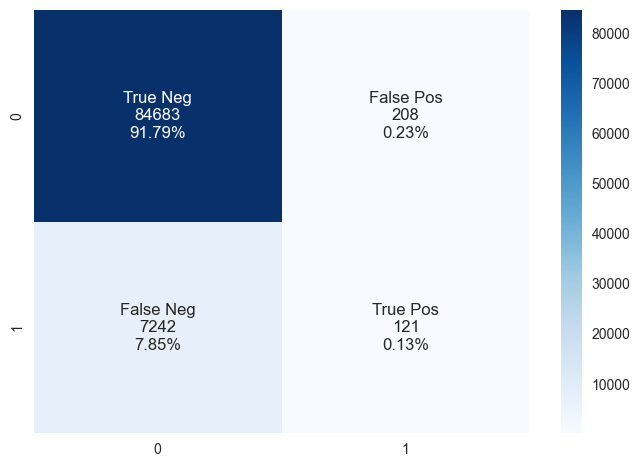

In [68]:
# Compute confusion matrix
Y_pred = np.argmax(model_final.predict_proba(X_test_bis), axis=1)
cf_matrix = confusion_matrix(y_test, Y_pred)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

<Axes: >

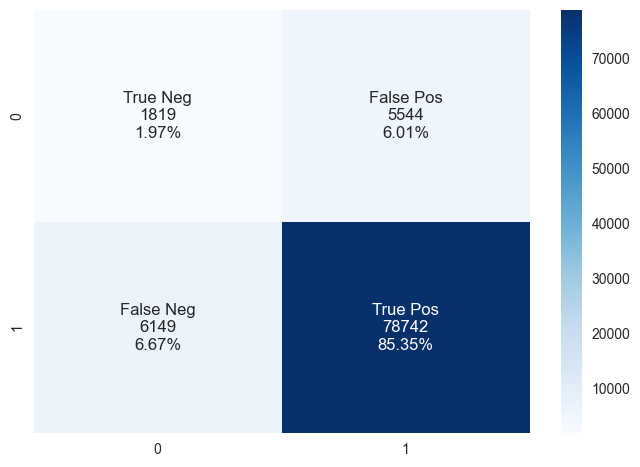

In [69]:
# Compute confusion matrix avec le seuil optimal
cf_matrix = confusion_matrix(y_test, y_pred_lgbm_optimal, labels=X_training['target'].unique())
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

## Importance des variables

#### Feature importance Ridge

In [70]:
coefficient = dict(zip(X.columns, ridge.coef_[0]))
coefficient_df = pd.DataFrame(data=coefficient.items(), columns=["features", "coef"])
coefficient_df.sort_values("coef", ascending=False).style.bar(
    color=["red", "green"], align="zero"
)

,features,coef
3,amt_income_total,0.337489
36,cnt_payment,0.256996
12,own_car_age,0.252990
2,cnt_children,0.180021
26,amt_balance,0.171966
15,region_rating_client,0.157605
37,days_first_drawing,0.147635
23,credit_active,0.127660
16,region_rating_client_w_city,0.115883
41,code_reject_reason,0.107471


#### Feature importance Logistic

##### Importance Globale

In [71]:
coefficient = dict(zip(X.columns, logistic.coef_[0]))
coefficient_df = pd.DataFrame(data=coefficient.items(), columns=["features", "coef"])
coef_log = coefficient_df.sort_values("coef", ascending=False).style.bar(
    color=["red", "green"], align="zero"
)
coef_log

,features,coef
26,amt_balance,0.368303
23,credit_active,0.331412
15,region_rating_client,0.310822
37,days_first_drawing,0.263865
36,cnt_payment,0.245340
9,region_population_relative,0.240772
29,sk_dpd_def,0.225502
12,own_car_age,0.224444
11,days_employed,0.210513
0,name_contract_type,0.163172


In [72]:
transformer.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('pipeline-1',
   Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                   ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]),
   Index(['name_contract_type', 'code_gender', 'name_type_suite',
          'name_income_type', 'name_education_type', 'name_family_status',
          'occupation_type', 'credit_active', 'name_contract_status',
          'code_reject_reason', 'name_client_type'],
         dtype='object')),
  ('pipeline-2',
   Pipeline(steps=[('simpleimputer', SimpleImputer()),
                   ('standardscaler', StandardScaler())]),
   Index(['cnt_children', 'amt_income_total', 'amt_credit_x',
          'region_population_relative', 'days_birth', 'days_employed',
          'own_car_age', 'cnt_fam_members', 'region_rating_client',
          'region_rating_client_w_city', 'hour_appr_process_start',
          'reg_city_no

In [73]:
cat_feat

Index(['name_contract_type', 'code_gender', 'name_type_suite',
       'name_income_type', 'name_education_type', 'name_family_status',
       'occupation_type', 'credit_active', 'name_contract_status',
       'code_reject_reason', 'name_client_type'],
      dtype='object')

In [74]:
# transformation inverse des variables après le preprocessing
num_list = list(num_feat)
cat_list = list(
    transformer.named_transformers_["pipeline-1"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(cat_feat)
)

all_var = num_list + cat_list
all_var

['cnt_children',
 'amt_income_total',
 'amt_credit_x',
 'region_population_relative',
 'days_birth',
 'days_employed',
 'own_car_age',
 'cnt_fam_members',
 'region_rating_client',
 'region_rating_client_w_city',
 'hour_appr_process_start',
 'reg_city_not_work_city',
 'totalarea_mode',
 'def_30_cnt_social_circle',
 'flag_document_3',
 'amt_req_credit_bureau_year',
 'days_credit',
 'amt_credit_sum',
 'amt_balance',
 'amt_payment_current',
 'sk_dpd_x',
 'sk_dpd_def',
 'days_instalment_delay',
 'amt_instalment_delta',
 'amt_annuity',
 'amt_credit_y',
 'amt_down_payment',
 'days_decision',
 'cnt_payment',
 'days_first_drawing',
 'days_last_due',
 'days_termination',
 'cnt_instalment_future',
 'sk_dpd_y',
 'name_contract_type_Cash loans',
 'name_contract_type_Revolving loans',
 'code_gender_F',
 'code_gender_M',
 'code_gender_XNA',
 'name_type_suite_Children',
 'name_type_suite_Family',
 'name_type_suite_Group of people',
 'name_type_suite_Other_A',
 'name_type_suite_Other_B',
 'name_type_su

In [75]:
# Enregistrer les variables permutées
joblib.dump(all_var, "all_var.joblib")

['all_var.joblib']

In [76]:
len(cat_list)

41

In [77]:
# Utilisation d' Eli5
perm = PermutationImportance(logistic, scoring="balanced_accuracy")
perm.fit(X_test_bis, y_test)
eli5.show_weights(perm, feature_names=all_var)

Weight,Feature
0.0238 ± 0.0035,name_type_suite_Unaccompanied
0.0215 ± 0.0023,name_family_status_married
0.0157 ± 0.0025,credit_active_Sold
0.0091 ± 0.0020,name_client_type_Repeater
0.0077 ± 0.0017,code_reject_reason_XAP
0.0062 ± 0.0026,flag_document_3
0.0059 ± 0.0027,code_reject_reason_VERIF
0.0053 ± 0.0018,name_contract_status_Canceled
0.0050 ± 0.0006,amt_down_payment
0.0049 ± 0.0014,days_instalment_delay


##### Importance locale

In [78]:
X_training[X_training["sk_id_curr"] == 100200]

,sk_id_curr,target,name_contract_type,code_gender,cnt_children,amt_income_total,amt_credit_x,name_type_suite,name_income_type,name_education_type,...,days_decision,cnt_payment,days_first_drawing,days_last_due,days_termination,name_contract_status,code_reject_reason,name_client_type,cnt_instalment_future,sk_dpd_y
171,100200,0,Cash loans,F,0,"216,000.0","450,000.0",Unaccompanied,working,low_educ,...,"-1,302.8",16.4,"365,243.0","121,036.66666666669","121,041.0",Approved,XAP,Repeater,11.833333333333334,0.0


In [79]:
X_transformed = transformer.transform(X)
X_val = pd.DataFrame(X_transformed)
X_val.columns = all_var
cl = X_training[X_training["sk_id_curr"] == 100200]
i = cl.index.values[0]

X_val.iloc[[i]]
plot = eli5.explain_prediction(logistic, X_val.iloc[i], feature_names=all_var)
plot

Explanation(estimator='LogisticRegression(n_jobs=-1)', description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='credit_active_Sold', weight=0.6257355827513743, std=None, value=-2.4818500883252685), FeatureWeight(feature='def_30_cnt_social_circle', weight=0.3195859128782619, std=None, value=1.0), FeatureWeight(feature='days_instalment_delay', weight=0.23027157649320712, std=None, value=1.0), FeatureWeight(feature='amt_credit_x', weight=0.2150041153195439, std=None, value=1.0), FeatureWeight(feature='credit_active_Active', weight=0.1718968832924712, std=None, value=-1.5664907999037052), FeatureWeight(feature='code_reject_reason_VERIF', weight=0.09865306771043843, std=None, value=-0.6833971822176994), FeatureWeight(feature='<BIAS>', weight=0.09736002153194177, std=None, value=1.0), FeatureWeight(feature='amt_annuity', weight=0.09510299786379263, std=None, value=1.0), FeatureWeight(feature='sk_dpd_x', weight=0.09500431088747933, std=None, value=1.0), FeatureWeight(feature='code_reject_reason_HC', weight=0.06969917519179383, std=None, value=-0.5204424584192002), FeatureWeight(feature='occupation_type_Low-skill Laborers', weight=0.0625759364645593, std=None, value=0.9910537822560274), FeatureWeight(feature='name_type_suite_Unaccompanied', weight=0.05729650963818863, std=None, value=-0.19779195006502343), FeatureWeight(feature='credit_active_Closed', weight=0.04149256018434868, std=None, value=0.6351102983564425), FeatureWeight(feature='name_client_type_Refreshed', weight=0.03486455844054091, std=None, value=0.310818704435516), FeatureWeight(feature='code_reject_reason_XNA', weight=0.03431535441154588, std=None, value=0.4110136355921312), FeatureWeight(feature='amt_balance', weight=0.028753005903755652, std=None, value=1.0), FeatureWeight(feature='name_family_status_other', weight=0.021449441953950685, std=None, value=-0.5475312505461951), FeatureWeight(feature='name_family_status_married', weight=0.018999512298858528, std=None, value=-0.06314294554682344), FeatureWeight(feature='occupation_type_other', weight=0.017640428447287554, std=None, value=-0.320123240520886), FeatureWeight(feature='code_reject_reason_SYSTEM', weight=0.006060843445212116, std=None, value=0.04747468874082873), FeatureWeight(feature='name_client_type_XNA', weight=0.001958661313511693, std=None, value=-0.06045204789973081), FeatureWeight(feature='name_income_type_working', weight=1.1731738913680758e-17, std=None, value=-2.5425494778461686e-16), FeatureWeight(feature='name_contract_status_Refused', weight=5.073694102106285e-18, std=None, value=1.3675608202897095e-16), FeatureWeight(feature='code_reject_reason_CLIENT', weight=4.612651777065672e-20, std=None, value=5.407083584525438e-18)], neg=[FeatureWeight(feature='amt_req_credit_bureau_year', weight=-0.310821581886663, std=None, value=1.0), FeatureWeight(feature='reg_city_not_work_city', weight=-0.21051280576353423, std=None, value=1.0), FeatureWeight(feature='cnt_children', weight=-0.16317240144614295, std=None, value=1.0), FeatureWeight(feature='name_contract_type_Revolving loans', weight=-0.1305406260229971, std=None, value=1.0), FeatureWeight(feature='code_reject_reason_SCO', weight=-0.09216644378614199, std=None, value=-0.5517351967608851), FeatureWeight(feature='name_type_suite_Children', weight=-0.09021131499283315, std=None, value=1.0), FeatureWeight(feature='name_contract_status_Approved', weight=-0.0483895097101706, std=None, value=-0.39192190555926903), FeatureWeight(feature='code_reject_reason_XAP', weight=-0.03543150986679588, std=None, value=0.2331456300339571), FeatureWeight(feature='name_family_status_not_married', weight=-0.027521833525518874, std=None, value=-0.6329004137507744), FeatureWeight(feature='name_type_suite_Group of people', weight=-0.026822051677339788, std=None, value=-0.5770970033833617), FeatureWeight(feature='name_client_type_New', weight=-0.02501256444714549, std=Non

#### Feature importance LGBM globale et locale avec Eli5

##### Feature importance globale

In [80]:
eli5.show_weights(model_final, feature_names=all_var, top=20)

Weight,Feature
0.1250,credit_active_Closed
0.1041,flag_document_3
0.0964,name_family_status_not_married
0.0658,code_reject_reason_LIMIT
0.0528,reg_city_not_work_city
0.0493,name_client_type_XNA
0.0449,region_population_relative
0.0417,"name_type_suite_Spouse, partner"
0.0383,days_instalment_delay
0.0349,name_type_suite_Other_A


In [81]:
perm = PermutationImportance(model_final, scoring="balanced_accuracy")
perm.fit(X_test_bis, y_test)
eli5.show_weights(perm, feature_names=all_var)

Weight,Feature
0.0016 ± 0.0007,code_reject_reason_VERIF
0.0012 ± 0.0003,amt_down_payment
0.0011 ± 0.0005,days_instalment_delay
0.0011 ± 0.0007,name_type_suite_Other_B
0.0010 ± 0.0003,credit_active_Sold
0.0009 ± 0.0005,name_contract_status_Canceled
0.0008 ± 0.0009,name_income_type_not_working
0.0008 ± 0.0005,credit_active_Active
0.0008 ± 0.0003,code_reject_reason_SCO
0.0007 ± 0.0001,amt_annuity


##### Feature importance locale LGBM

In [82]:
X_transformed = transformer.transform(X)
X_val = pd.DataFrame(X_transformed)
X_val.columns = all_var
cl = X_training[X_training["sk_id_curr"] == 100200]
i = cl.index.values[0]

# i = 4
X_val.iloc[[i]]
plot = eli5.explain_prediction(model_final, X_val.iloc[i], feature_names=all_var)
plot

Explanation(estimator='LGBMClassifier(colsample_bytree=0.8, max_depth=12, n_estimators=200,\n               num_leaves=64, subsample=1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='name_family_status_not_married', weight=0.8749309988557455, std=None, value=-0.6329004137507744), FeatureWeight(feature='credit_active_Closed', weight=0.5797167367947332, std=None, value=0.6351102983564425), FeatureWeight(feature='name_type_suite_Spouse, partner', weight=0.4300293445250989, std=None, value=0.3994328184545127), FeatureWeight(feature='region_population_relative', weight=0.40755523962126194, std=None, value=0.0), FeatureWeight(feature='credit_active_Sold', weight=0.38757601395788654, std=None, value=-2.4818500883252685), FeatureWeight(feature='code_reject_reason_LIMIT', weight=0.2738572834788857, std=None, value=-0.13699976565981153), FeatureWeight(feature='credit_active_Active', weight=0.24383949214301268, std=None, value=-1.5664907999037052), FeatureWeight(feature='occupation_type_Low-skill Laborers', weight=0.2355141937074747, std=None, value=0.9910537822560274), FeatureWeight(feature='code_reject_reason_SYSTEM', weight=0.22371135864609581, std=None, value=0.04747468874082873), FeatureWeight(feature='name_client_type_XNA', weight=0.2071746499214235, std=None, value=-0.06045204789973081), FeatureWeight(feature='code_reject_reason_VERIF', weight=0.1730539734483538, std=None, value=-0.6833971822176994), FeatureWeight(feature='reg_city_not_work_city', weight=0.1601743525999562, std=None, value=1.0), FeatureWeight(feature='days_instalment_delay', weight=0.12637757519982348, std=None, value=1.0), FeatureWeight(feature='amt_credit_x', weight=0.12433914845669827, std=None, value=1.0), FeatureWeight(feature='code_reject_reason_XNA', weight=0.12062473886535202, std=None, value=0.4110136355921312), FeatureWeight(feature='name_income_type_not_working', weight=0.11003391916612491, std=None, value=-0.4690439473613174), FeatureWeight(feature='name_type_suite_Unaccompanied', weight=0.09219093269003309, std=None, value=-0.19779195006502343), FeatureWeight(feature='sk_dpd_def', weight=0.09015882053809293, std=None, value=0.0), FeatureWeight(feature='name_client_type_Refreshed', weight=0.0877565941048877, std=None, value=0.310818704435516), FeatureWeight(feature='name_client_type_New', weight=0.08704025068964603, std=None, value=0.37966609092991715), FeatureWeight(feature='amt_annuity', weight=0.08577549868707318, std=None, value=1.0), FeatureWeight(feature='name_contract_status_Approved', weight=0.07991107512822085, std=None, value=-0.39192190555926903), FeatureWeight(feature='code_gender_M', weight=0.07624205179929536, std=None, value=0.0), FeatureWeight(feature='days_credit', weight=0.06377347854227483, std=None, value=0.0), FeatureWeight(feature=

In [83]:
# Sérialiser le modèle lgbm
import joblib

joblib.dump(model_final, "./models/model_final_2.joblib")

['./models/model_final_2.joblib']

In [84]:
# Sérialiser le modèle logistic
import joblib

joblib.dump(logistic, "./backend/models/model_final_log.joblib")

['./backend/models/model_final_log.joblib']

In [85]:
# save the preprocessor
joblib.dump(transformer, "./models/transformer.sav")

['./models/transformer.sav']

In [86]:
test_model = joblib.load("./models/model_final_2.joblib")
test_model.predict_proba(X_test_bis)

array([[0.82100449, 0.17899551],
       [0.95334996, 0.04665004],
       [0.96051205, 0.03948795],
       ...,
       [0.93659217, 0.06340783],
       [0.95943134, 0.04056866],
       [0.97746711, 0.02253289]])

In [87]:
df_transformed = transformer.transform(
    X_training.iloc[0:10000].drop(columns=["target"], axis=1)
)

### Déploiement avec MLflow

In [88]:
from mlflow.models.signature import infer_signature

signature = infer_signature(X_sm, y_sm)

#### Sauvegarde du modèle sklearn

In [ ]:
import mlflow.sklearn

mlflow.sklearn.save_model(model_final, "model_final_lgbm", signature=signature)